# Excel

Lendo a planilha Excel em [https://github.com/ocefpaf/CursoPython_AlunasJu/issues/5](https://github.com/ocefpaf/CursoPython_AlunasJu/issues/5).

Parece que tem dados depois de espaços em branco na mesma coluna. Abrindo a planilha parece que os dados de interesse terminam em ano 1732, amostra `AMCO564`, linha 79.

In [1]:
import pandas as pd


skiprows = 2

df = pd.read_excel(
    "TOC.xlsx",
    skiprows=skiprows,
    nrows=79 - skiprows - 1,  # header + extra/blanks rows.
)

df.tail()

,Amostra,Ano,Rock Eval,LECO
71,AMCO547,1837.0,0.80,0.717591
72,AMCO551,1813.0,0.87,0.743635
73,AMCO555,1789.0,0.88,0.826678
74,AMCO560,1757.0,0.92,0.827944
75,AMCO564,1732.0,0.63,0.733384


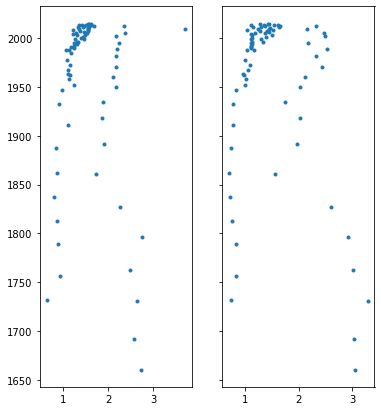

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6, 7), sharey=True)

ax0.plot(df["Rock Eval"].values, df["Ano"], ".")
ax1.plot(df["LECO"].values, df["Ano"], ".")

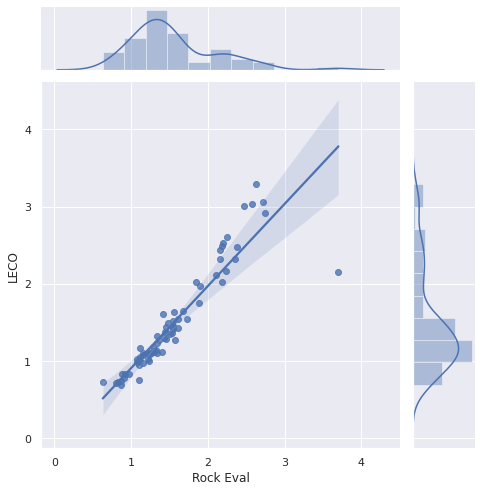

In [3]:
import seaborn


seaborn.set(style="darkgrid")

g = seaborn.jointplot("Rock Eval", "LECO", data=df, kind="reg", height=7,)

# NetCDF

In [4]:
from netCDF4 import Dataset


nc = Dataset("woa01an.nc")
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: WOA01 CLIMATOLOGY Levitus annual
    author: J Grelet IRD US025 Brest
    date: 16 Nov 2004
    dimensions(sizes): WOA01_LATX(180), WOA01_LONX(360), WOA01_DEPH(33)
    variables(dimensions): float32 WOA01_LATX(WOA01_LATX), float32 WOA01_LONX(WOA01_LONX), float32 WOA01_DEPH(WOA01_DEPH), float32 WOA01_MEAN_TEMP(WOA01_LATX,WOA01_LONX,WOA01_DEPH), float32 WOA01_MEAN_PSAL(WOA01_LATX,WOA01_LONX,WOA01_DEPH), float32 WOA01_MEAN_DOX1(WOA01_LATX,WOA01_LONX,WOA01_DEPH), float32 WOA01_STD_TEMP(WOA01_LATX,WOA01_LONX,WOA01_DEPH), float32 WOA01_STD_PSAL(WOA01_LATX,WOA01_LONX,WOA01_DEPH), float32 WOA01_STD_DOX1(WOA01_LATX,WOA01_LONX,WOA01_DEPH), int16 WOA01_OBS_TEMP(WOA01_LATX,WOA01_LONX,WOA01_DEPH), int16 WOA01_OBS_PSAL(WOA01_LATX,WOA01_LONX,WOA01_DEPH), int16 WOA01_OBS_DOX1(WOA01_LATX,WOA01_LONX,WOA01_DEPH)
    groups: 

In [5]:
import numpy as np

lon = nc["WOA01_LONX"][:]
lat = nc["WOA01_LATX"][:]
temp = nc["WOA01_MEAN_TEMP"][:]
sal = nc["WOA01_MEAN_PSAL"][:]
depth = nc["WOA01_DEPH"][:]

maskx = np.logical_and(lon < -5.5, lon > -45.5)
masky = np.logical_and(lat < 0, lat > -45)

temp = temp[masky, ...][:, maskx, :].mean(axis=0).mean(axis=0)
sal = sal[masky, ...][:, maskx, :].mean(axis=0).mean(axis=0)

Text(0.5, 0, 'Salinidade [g kg$^{-1}$]')

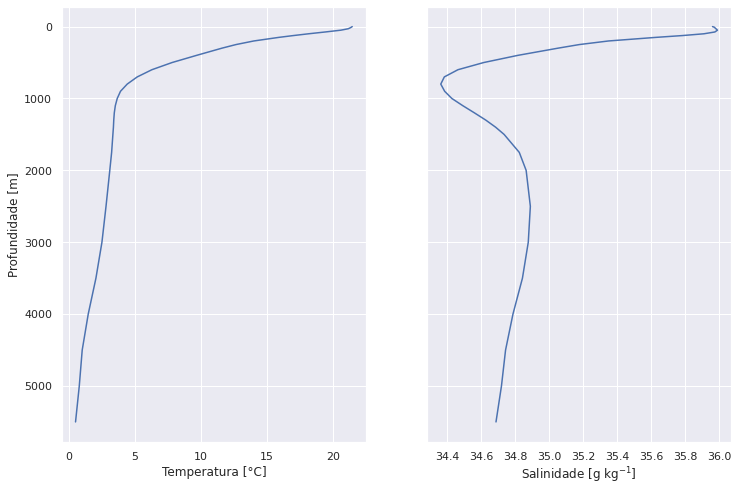

In [6]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 8))

ax0.invert_yaxis()

ax0.plot(temp, depth)
ax0.set_xlabel(u"Temperatura [\u00B0C]")
ax0.set_ylabel("Profundidade [m]")

ax1.plot(sal, depth)
ax1.set_xlabel(r"Salinidade [g kg$^{-1}$]")

# OPeNDAP

In [7]:
from netCDF4 import Dataset


url = "http://goosbrasil.org:8080/pirata/B19s34w.nc"
nc = Dataset(url)

temp = nc["temperature"][:]
times = nc["time"]

In [8]:
temp[temp <= -9999] = np.NaN

In [9]:
import cftime
import nc_time_axis


t = cftime.num2date(times[:], times.units, calendar=times.calendar,)

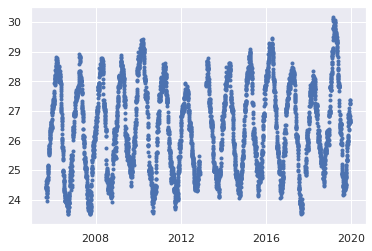

In [10]:
fig, ax = plt.subplots()

ax.plot(t, temp[:, 0], ".")

## Mesmo com xarray/iris CF - Climate Forecast

In [11]:
import xarray as xr

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:        (depth_s: 8, depth_t: 15, time: 5373)
Coordinates:
  * depth_s        (depth_s) float32 1.0 5.0 10.0 20.0 40.0 60.0 80.0 120.0
  * depth_t        (depth_t) float32 1.0 5.0 10.0 13.0 ... 180.0 300.0 500.0
  * time           (time) datetime64[ns] 2005-08-31T12:00:00 ... 2020-05-16T12:00:00
Data variables:
    rad            (time) float32 ...
    salinity_q     (time, depth_s) float32 ...
    rh_q           (time) float32 ...
    salinity_s     (time, depth_s) float32 ...
    qsen_q         (time) float32 ...
    rh_s           (time) float32 ...
    rain_percent   (time) float32 ...
    bp_s           (time) float32 ...
    bp_q           (time) float32 ...
    temperature    (time, depth_t) float32 ...
    rad_s          (time) float32 ...
    lw             (time) float32 ...
    airt           (time) float32 ...
    rain_s         (time) float32 ...
    latitude       (time) float32 ...
    rain_q         (time) float32 ...
    rh             (time) float32 ...
    temperature_s  (time, depth_t) float32 ...
    rain_std       (time) float32 ...
    ws_s           (time) float32 ...
    lon_q          (time) float32 ...
    wd             (time) float32 ...
    qlat_q         (time) float32 ...
    ws_q           (time) float32 ...
    rain           (time) float32 ...
    rad_peak       (time) float32 ...
    bp             (time) float32 ...
    airt_s         (time) float32 ...
    airt_q         (time) float32 ...
    lat_q          (time) float32 ...
    qsen           (time) float32 ...
    rad_std        (time) float32 ...
    wd_q           (time) float32 ...
    wd_s           (time) float32 ...
    qlat           (time) float32 ...
    lw_s           (time) float32 ...
    lw_q           (time) float32 ...
    salinity_id    (time, depth_s) float32 ...
    rad_q          (time) float32 ...
    longitude      (time) float32 ...
    salinity       (time, depth_s) float32 ...
    ws             (time) float32 ...
    temperature_q  (time, depth_t) float32 ...
Attributes:
    comment:          These data were obtained from Pacific Marine Environmen...
    source:           Moored buoy from PIRATA
    history:          Created Tue May 19 17:08:20 2020
    description:      Buoy 19s34w
    missing_value:    -99999
    data_management:  SALT - Sea & Limno Technology
    institution:      GOOS-Brasil

In [12]:
temp = ds["temperature"]

temp

<xarray.DataArray 'temperature' (time: 5373, depth_t: 15)>
array([[ 2.4420e+01, -9.9999e+04, -9.9999e+04, ...,  1.6910e+01,  1.4660e+01,
         1.0690e+01],
       [ 2.4390e+01, -9.9999e+04, -9.9999e+04, ...,  1.7030e+01,  1.4710e+01,
         1.0640e+01],
       [ 2.4410e+01, -9.9999e+04, -9.9999e+04, ...,  1.7230e+01,  1.4740e+01,
         1.0540e+01],
       ...,
       [-9.9990e+03, -9.9990e+03,  2.7040e+01, ...,  2.0440e+01,  1.4500e+01,
        -9.9990e+03],
       [-9.9990e+03, -9.9990e+03,  2.7160e+01, ...,  2.0450e+01,  1.4550e+01,
        -9.9990e+03],
       [-9.9990e+03, -9.9990e+03,  2.7250e+01, ...,  2.0560e+01,  1.4660e+01,
        -9.9990e+03]], dtype=float32)
Coordinates:
  * depth_t  (depth_t) float32 1.0 5.0 10.0 13.0 ... 140.0 180.0 300.0 500.0
  * time     (time) datetime64[ns] 2005-08-31T12:00:00 ... 2020-05-16T12:00:00
Attributes:
    units:      Degree Celsius
    long_name:  Temperature

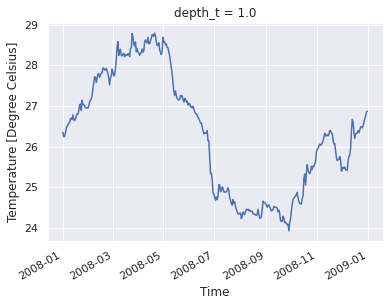

In [13]:
temp.sel(depth_t=1.0, time="2008").plot()

# CDS

https://cds.climate.copernicus.eu/api-how-to

In [14]:
import cdsapi

c = cdsapi.Client()

name = "reanalysis-era5-pressure-levels"
request = {
    "year": "2008",
    "month": "01",
    "day": "01",
    "time": "12:00",
    "variable": "temperature",
    "pressure_level": "1000",
    "product_type": "reanalysis",
    "format": "netcdf",
}

r = c.retrieve(name, request, None)

2020-05-19 17:14:15,438 INFO Welcome to the CDS
2020-05-19 17:14:15,441 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-05-19 17:14:17,466 INFO Request is completed


In [15]:
r.location

'http://136.156.132.105/cache-compute-0000/cache/data6/adaptor.mars.internal-1589420814.9866006-406-5-99e3a75e-53c3-4e36-bbfd-a992f5d2fdf2.nc'

In [16]:
import fsspec
import xarray as xr


with fsspec.open(r.location) as f:
    ds = xr.open_dataset(f)

ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01T12:00:00
Data variables:
    t          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-14 01:46:55 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

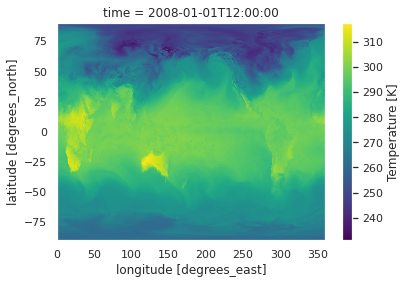

In [17]:
temp = ds["t"].squeeze()

temp.plot()

# ERDDAP

In [18]:
from erddapy import ERDDAP


e = ERDDAP(server="https://data.ioos.us/gliders/erddap", protocol="tabledap",)

In [19]:
e.dataset_id = "whoi_406-20160902T1700"

e.constraints = {
    "time>=": "2016-07-10T00:00:00Z",
    "time<=": "2017-02-10T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}

e.variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]


url = e.get_download_url()

print(url)

https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.html?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0


In [20]:
import pandas as pd


df = e.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-03 20:15:46+00:00,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46+00:00,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46+00:00,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46+00:00,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46+00:00,8.43,40.990881,-71.12439,32.224503,20.5691


Text(0, 0.5, 'Depth (m)')

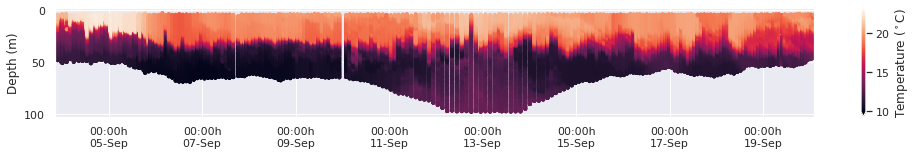

In [21]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(
    df.index,
    df["depth (m)"],
    s=15,
    c=df["temperature (Celsius)"],
    marker="o",
    edgecolor="none",
)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_ylabel("Depth (m)")

One server to rule them all!

In [22]:
e.get_download_url(response="opendap")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700'

In [23]:
e.get_download_url(response="mat")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

In [24]:
e.get_download_url(response="csv")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.csv?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

In [25]:
e.get_download_url(response="json")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.json?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

In [26]:
e.get_download_url(response="ncCF")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.ncCF?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

In [27]:
e.get_download_url(response="ncCFHeader")

'https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.ncCFHeader?depth,latitude,longitude,salinity,temperature,time&time>=1468108800.0&time<=1486684800.0&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0'

# Data Access Gallery

https://ioos.github.io/notebooks_demos/code_gallery/

Exercício: Encontre um set de dados em

https://coastwatch.pfeg.noaa.gov/erddap/info/index.html

e, usando o `erddapy` faça um gráfico com o dado escolhido.